## Polygon Overlap with Open Source Data

The code provided here will show you how to take in spatial, polygonal data and produce maps that represent the overlap, and local proximity, of two separate groups/classes/sets/etc of polygons. 

The tools included here are able to handle any spatial, polygon-based data. For the purposes of visualization and to provide an example use case, I have used open source geospatial data provided by the BCGS [https://www2.gov.bc.ca]

The primary goals of this toolset are to take in two sets of polygons (in this case, the locations of unique types of rock found in the earth's crust), and produce a heatmap that shows their overlap and general proximity to one another. Both the overall search area and the precision of the resultant map are adjustable.


In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from shapely.ops import unary_union
import time

%matplotlib inline

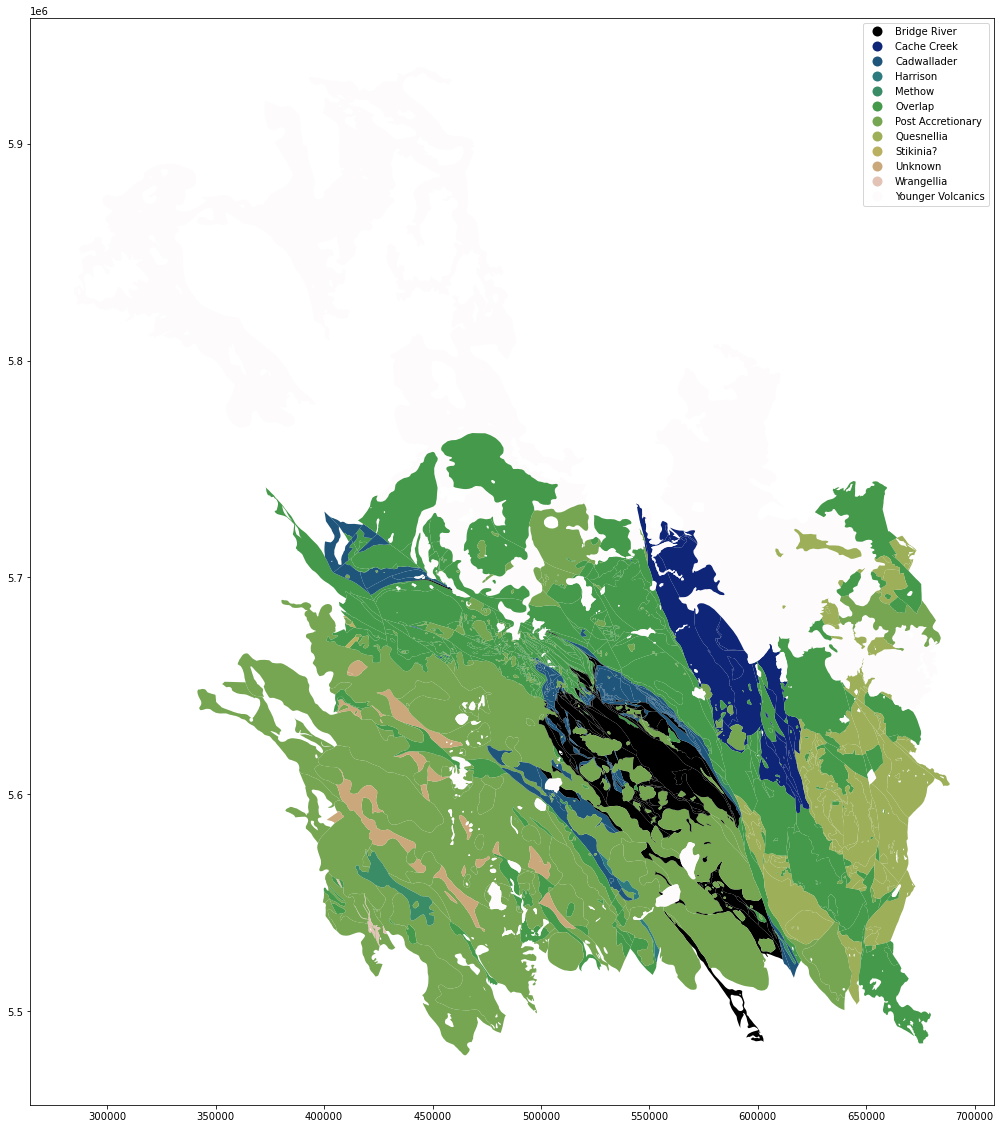

In [2]:
fName = '/Users/Eichenbaum/Desktop/github/Data/BedrockP.shp'
bedrock_data = gpd.read_file(fName) 

_ = bedrock_data.plot(column="terrane", categorical=True, legend=True, figsize=(20,20), cmap='gist_earth')

In [3]:
def test_rock_data():
    """
    Test to make sure the Rock Type specified is the Rock Type(s) included in the produced dataframe. 
    """
    fPath = fName  
    test_data = gpd.read_file(fPath) 
    
    rock_type_selectedStr =  'calc-alkaline volcanic rocks' # 'calc-alkaline volcanic rocks' 'mixed volcanic and sedimentary rocks'
    rock_type_dataset = IsolateRockData(test_data, rock_type_selectedStr)
    
    rock_type_recoveredStr = np.unique(rock_type_dataset['rock_type'])
    
    assert np.all([rock_type_selectedStr in rock_type_recoveredStr[i] for i in range(len(rock_type_recoveredStr))])

In [4]:
def test_precision_val():
    """
    Test to make sure the precision value is correct in Overlap Map output. Resultant dataframe should have
    n+1 rows: the nLevels specified by the 'precision' + the original, non-buffered intersection layer
    """

    fPath = fName 
    test_data = gpd.read_file(fPath) 
    
    test_rType1 = 'calc-alkaline volcanic rocks'
    test_rType2 = 'mixed volcanic and sedimentary rocks'
    search_distance = 10000
    precision = 15
    
    testOverlapMap = FindMyOverlap(test_data, test_rType1, test_rType2, search_distance, precision)

    assert len(testOverlapMap) == precision + 1

In [5]:
def IsolateRockData(bedrock_dataframe, rock_type):
    """
    Parameters
    ----------
    bedrock_dataframe : (GeoPandas) dataframe
        The dataframe that stores your geospatial information. GeoPandas dataframes work well
        
    rock_type : str 
        The name of the rock_type you want included in your search
        
    Output
    ------
    rock_type_dataset: (GeoPandas) dataframe
        A GeoPandas dataframe containing data only for the rock_type specified
        
    
    """    
    
    idxs = [idx for idx, rock in enumerate(bedrock_dataframe['rock_type']) if rock_type in rock]
    rock_type_dataset = bedrock_dataframe.iloc[idxs,:]
    
    return rock_type_dataset

In [6]:
def CreateRockTypeUnion(rock_type_dataset, buffersize):
    """
    Parameters
    ----------
    rock_type_dataset : (GeoPandas) dataframe
        The dataframe that stores your rock_type-specific geospatial information
    
    buffersize: int
        The value (in meters) you want to expand/buffer your polygon(s) by
        
    Output
    ------
    rock_type_union : Shapely (Multi)polygon
        A single Multipolygon whose area represents the full area of the rock_type of interest,
        expanded by the specified buffer size
    
    
    """
    geo_col_idx = np.argwhere(rock_type_dataset.columns=='geometry')[0][0]
    rock_type_geometry = [rock_type_dataset.iloc[j, geo_col_idx].buffer(buffersize) for j in range(len(rock_type_dataset))]
    rock_type_union = unary_union(rock_type_geometry)
    
    return rock_type_union

In [7]:
def FindMyOverlap(bedrock_dataframe, rock_type1, rock_type2, search_distance=10000, precision=15):
    """
    Welcome to FIND MY OVERLAP.
    
    This function will produce a heatmap, in the form of a series of Shapely (multi)polygons, 
    that shows where different rock types overlap, or are within a certain proximity of each other. 
    This funciton will work for any two rock types included in a BCGS bedrock shapefile. 
    Users must specify the following:
    
    Parameters
    ----------
    bedrock_dataframe : (GeoPandas) dataframe
        The dataframe that stores your geospatial information. GeoPandas dataframes work well
    
    rock_type1 : str 
        The name of the 1st rock_type you want included in your search (order does not matter)
    
    rock_type2 : str
        The name of the 2nd rock_type you want included in your search (order does not matter)
    
    search_distance : int
        [default = 10,000]. The maximum boundary area to be search for each rock_type
        (units in meters)
    
    precision : int 
        [default = 15]. The step function that determines the resolution of the resultant heatmap.
        Greater values = greater precision.
    
    Output:
    ------
    buffs_gpd: GeoPandas dataframe 
        A GeoPandas dataframe containing a set of polygons and the associated likelihood of finding
        overlap within those areas
    
    All rights reserved: Adam Eichenbaum February 13, 2021
    
    """
    ## Check to make sure the search_distance fits a specified criteria (e.g., between 5-10km)
    if np.logical_or(search_distance < 5000, search_distance > 10000):
        raise ValueError('Provided distance does not meet required range [5,000m - 10,000m]')
    
    ## Isolate the data from the bedrock dataframe associated with Rock Type #1 and Rock Type#2
    rock_type1_dataset = IsolateRockData(bedrock_dataframe, rock_type1)
    rock_type2_dataset = IsolateRockData(bedrock_dataframe, rock_type2)

    ## Set the step-size for each ring buffer based on search distance and precision
    buffer_increment = np.divide(search_distance, precision)

    buff_Unions = []

    ## Loop through steps (n = precision) to create successively smaller buffers to determine overlap
    ## between rock types. Add 1 (i.e., range to -1) so as to include a non-buffered overlap layer
    for i in range(precision,-1,-1):

        ## If final loop, do not alter the size of the polygon (i.e., buffersize is ~0)
        if i == 0: buffersize = 0.0001
        else: bufferSize = np.multiply(buffer_increment, i)

        ## Create the overall union for all buffered areas of each Rock Type
        rock_type1_union = CreateRockTypeUnion(rock_type1_dataset, bufferSize)
        rock_type2_union = CreateRockTypeUnion(rock_type2_dataset, bufferSize)
        
        ## Store only the areas where the Rock Type buffers overlap
        buff_Unions.append(rock_type2_union.intersection(rock_type1_union))

    ## Value of overlap/proximity between specified Rock Types
    overlap_likelihood = np.round(np.linspace(np.divide(buffer_increment, search_distance), 100, precision+1),2)

    ## Store heatmap polygons and likelihood values in GeoPandas dataframe
    buffs_gpd = gpd.GeoDataFrame(pd.DataFrame(
    {'overlap_likelihood': overlap_likelihood,
    'geometry': buff_Unions})) 
    
    return buffs_gpd

In [8]:
test_rock_data()

In [9]:
test_precision_val()

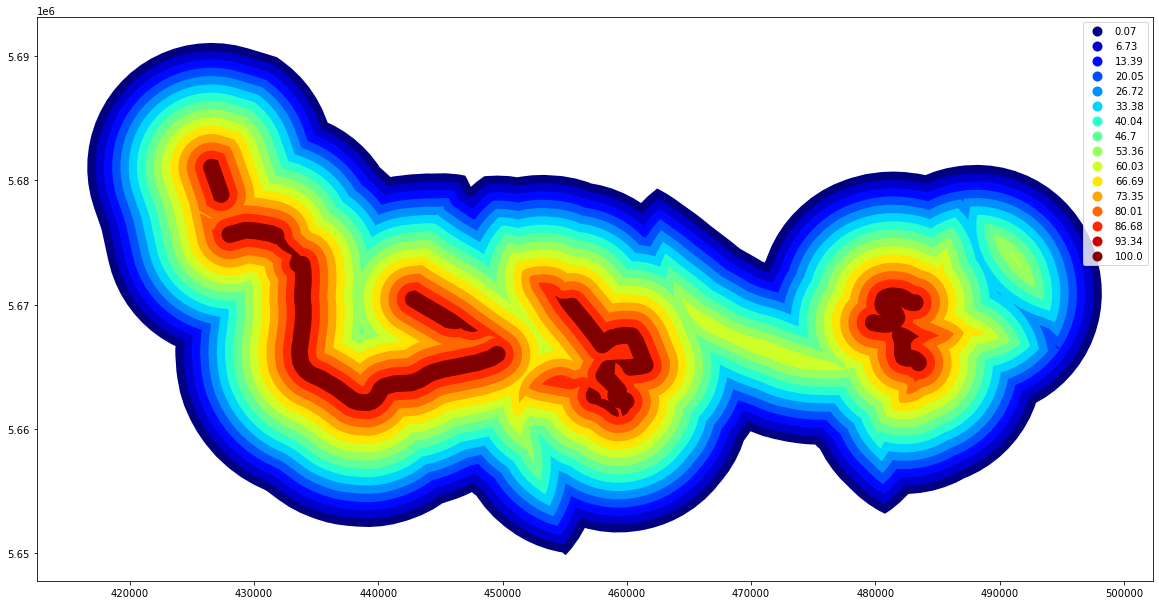

In [10]:
## Set your Rock Type and numerical values for FindMyOverlap
rock_type1 = 'calc-alkaline volcanic rocks'
rock_type2 = 'mixed volcanic and sedimentary rocks'
search_distance = 10000
precision = 15

## Run funciton to produce heatmap

# start = time.time()
myOverlapMap = FindMyOverlap(bedrock_data, rock_type1, rock_type2, search_distance, precision)
# end = time.time()
# print(end - start)

## Plot resultant heatmap
_ = myOverlapMap.plot(column = 'overlap_likelihood', categorical = True, legend =True, figsize = (20,14), cmap='jet')